# Problem Statement

Customer Churn is a burning problem for Telecom companies. Almost every telecom company pays a premium to get a customer on-board. Customer churn is a directly impacts company’s revenue.
  
In this case-study, we simulate one such case of customer churn where we work on a data of post-paid customers with a contract. The data has information about customer usage behaviour, contract details, and payment details. The data also indicates which were the customers who cancelled their service.  
  
Based on this past data, Perform an EDA and build a model which can predict whether a customer will cancel their service in the future or not.

# Data Dictionary

* <b>Churn</b> - 1 if customer cancelled service, 0 if not
* <b>AccountWeeks</b> - number of weeks customer has had active account
* <b>ContractRenewal</b> - 1 if customer recently renewed contract, 0 if not
* <b>DataPlan</b> - 1 if customer has data plan, 0 if not
* <b>DataUsage</b> - gigabytes of monthly data usage
* <b>CustServCalls</b> - number of calls into customer service
* <b>DayMins</b> - average daytime minutes per month
* <b>DayCalls</b> - average number of daytime calls
* <b>MonthlyCharge</b> - average monthly bill
* <b>OverageFee</b> - largest overage fee in last 12 months
* <b>RoamMins</b> - average number of roaming minutes


In [1]:
#Import all necessary modules
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics,model_selection
from sklearn.preprocessing import scale

In [2]:
cell_df = pd.read_excel("Cellphone.xlsx")

## EDA

In [3]:
cell_df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,1,108.0,0.0,0.0,0.38,2.0,115.1,114.0,41.8,10.57,13.8
1,0,113.0,1.0,1.0,3.59,1.0,44.9,63.0,55.9,6.71,13.3
2,0,101.0,1.0,0.0,0.00,0.0,257.3,84.0,60.0,9.24,13.5
3,0,80.0,1.0,1.0,2.89,4.0,166.4,92.0,77.9,11.92,10.7
4,0,70.0,1.0,0.0,0.00,0.0,175.4,130.0,44.0,7.98,11.6


In [4]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3303 non-null   float64
 2   ContractRenewal  3315 non-null   float64
 3   DataPlan         3324 non-null   float64
 4   DataUsage        3317 non-null   float64
 5   CustServCalls    3281 non-null   float64
 6   DayMins          3298 non-null   float64
 7   DayCalls         3322 non-null   float64
 8   MonthlyCharge    3320 non-null   float64
 9   OverageFee       3309 non-null   float64
 10  RoamMins         3326 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 286.6 KB


There are missing values in some coumns.  
All variables are of numeric type and does not contain any data inconsistencies (causing numeric variables to be object due to some special characters present in the data).  
Churn is the target variable.   
Churn, ContractRenewal and DataPlan are binary variables.

In [5]:
cell_df[['AccountWeeks','DataUsage','CustServCalls','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins']].describe().T.round(0)

,count,mean,std,min,25%,50%,75%,max
AccountWeeks,3303.0,101.0,40.0,1.0,74.0,101.0,127.0,243.0
DataUsage,3317.0,1.0,1.0,0.0,0.0,0.0,2.0,5.0
CustServCalls,3281.0,2.0,1.0,0.0,1.0,1.0,2.0,9.0
DayMins,3298.0,180.0,55.0,0.0,144.0,180.0,217.0,351.0
DayCalls,3322.0,100.0,20.0,0.0,87.0,101.0,114.0,165.0
MonthlyCharge,3320.0,56.0,16.0,14.0,45.0,54.0,66.0,111.0
OverageFee,3309.0,10.0,3.0,0.0,8.0,10.0,12.0,18.0
RoamMins,3326.0,10.0,3.0,0.0,8.0,10.0,12.0,20.0


### Check for Missing values

In [6]:
cell_df.isnull().sum()

Churn               0
AccountWeeks       30
ContractRenewal    18
DataPlan            9
DataUsage          16
CustServCalls      52
DayMins            35
DayCalls           11
MonthlyCharge      13
OverageFee         24
RoamMins            7
dtype: int64

### Imputing missing values

Since, ContractRenewal and DataPlan are binary, we cannot substitute with mean values for these 2 variables. We will impute these two variables with their respective modal values.

In [7]:
# Compute Mode for the 'Contract Renewal' and 'DataPlan' columns and impute the missing values
cols = ['ContractRenewal','DataPlan']
for column in cols:
    print(column)
    mode_1 = cell_df[column].mode()[0]
    print(mode_1)
    cell_df[column].fillna(value=mode_1, inplace=True)
    
    
cell_df.isnull().sum()

ContractRenewal
1.0
DataPlan
0.0


Churn               0
AccountWeeks       30
ContractRenewal     0
DataPlan            0
DataUsage          16
CustServCalls      52
DayMins            35
DayCalls           11
MonthlyCharge      13
OverageFee         24
RoamMins            7
dtype: int64

Now let us impute the rest of the continuous variables with the median. For that we are going to use the SimpleImputer sub module from sklearn.

In [8]:
from sklearn.impute import SimpleImputer
SI = SimpleImputer(strategy='median')

In [9]:
#Now we need to fit and transform our respective data set to fill the missing values with the corresponding 'median' values
cell_df = pd.DataFrame(SI.fit_transform(cell_df), columns=cell_df.columns)


### Checking for Duplicates

In [10]:
# Are there any duplicates ?
dups = cell_df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


### Proportion in the Target classes

In [11]:
cell_df.Churn.value_counts(normalize=True)

0.0    0.855086
1.0    0.144914
Name: Churn, dtype: float64

#  Univariate analysis

### Distribution of the variables Check using Histogram

In [12]:
from pylab import rcParams

In [13]:
rcParams['figure.figsize'] = 15,8

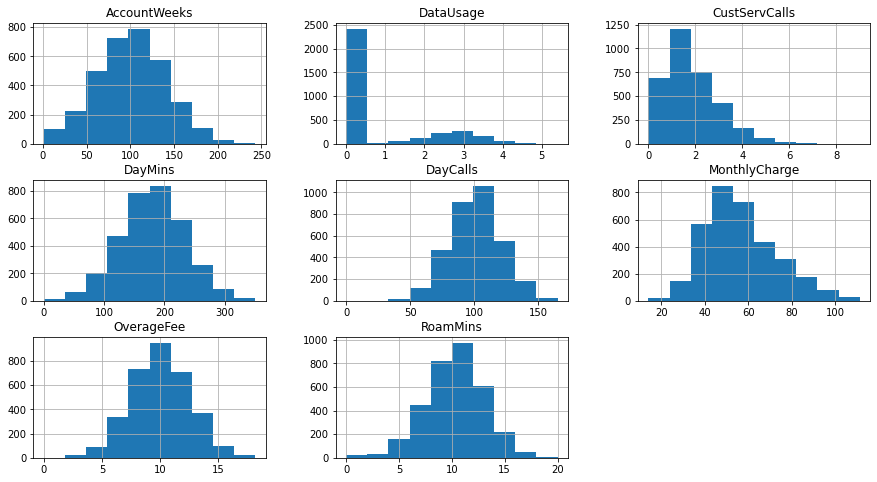

In [14]:
cell_df[['AccountWeeks','DataUsage','CustServCalls','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins']].hist();

### Outlier Check using boxplots

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


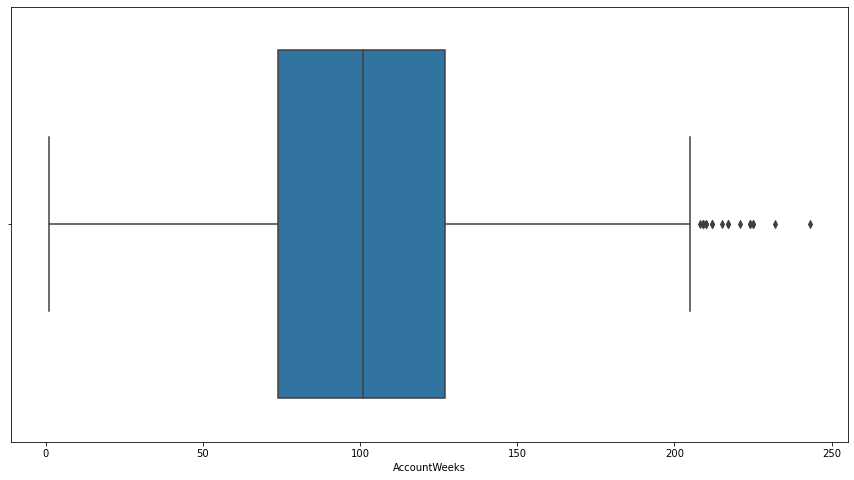

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


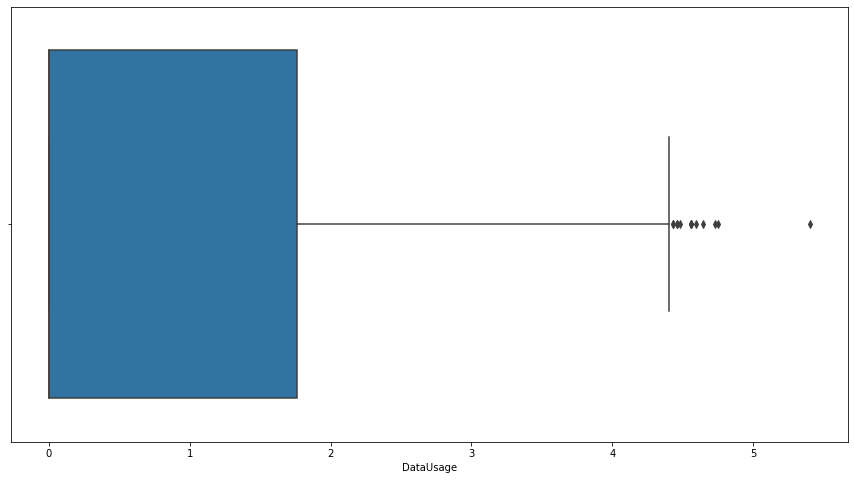

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


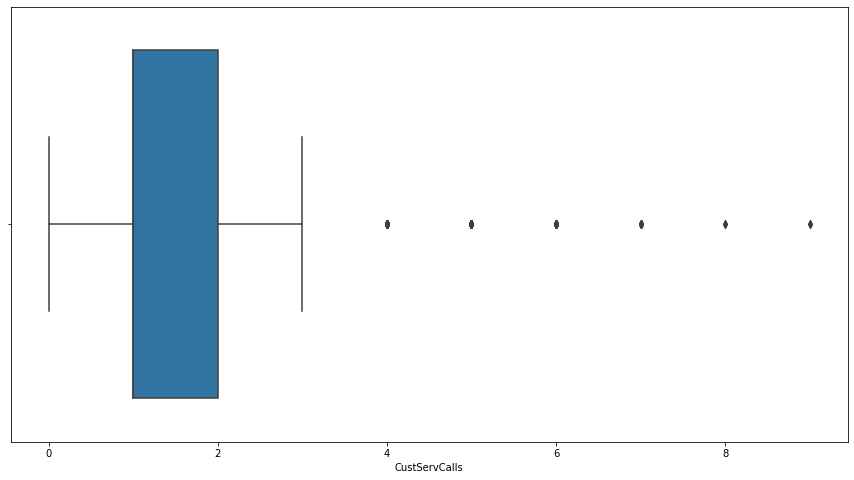

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


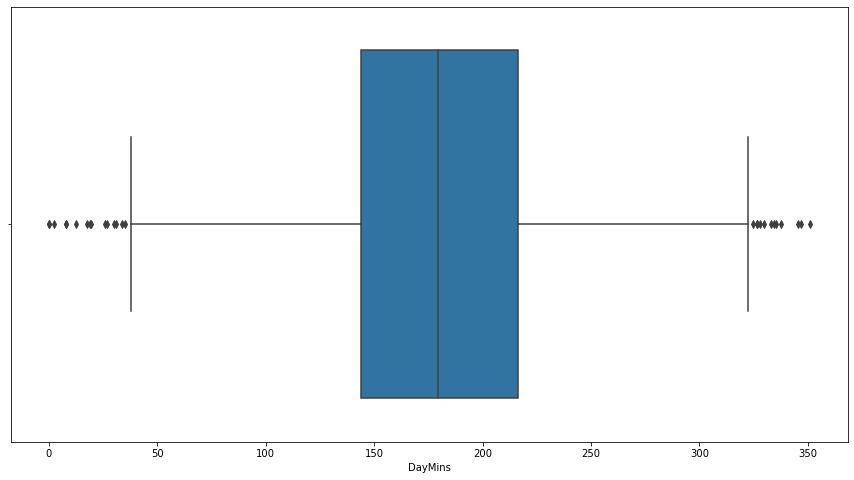

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


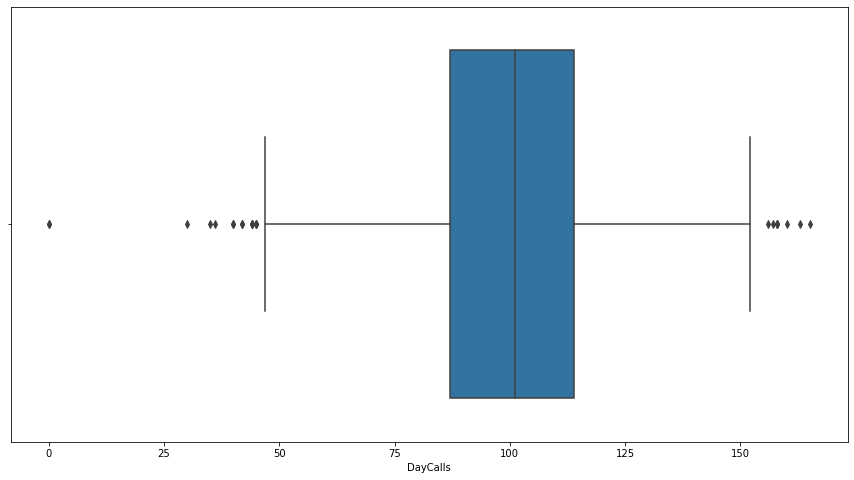

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


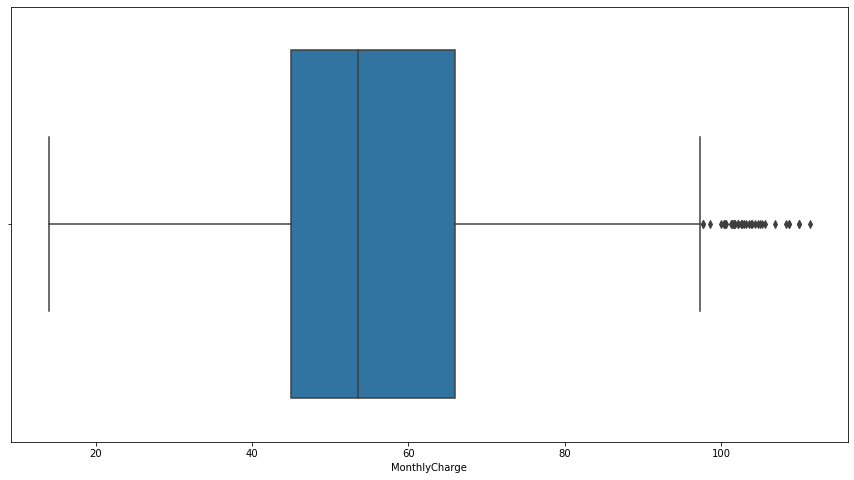

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


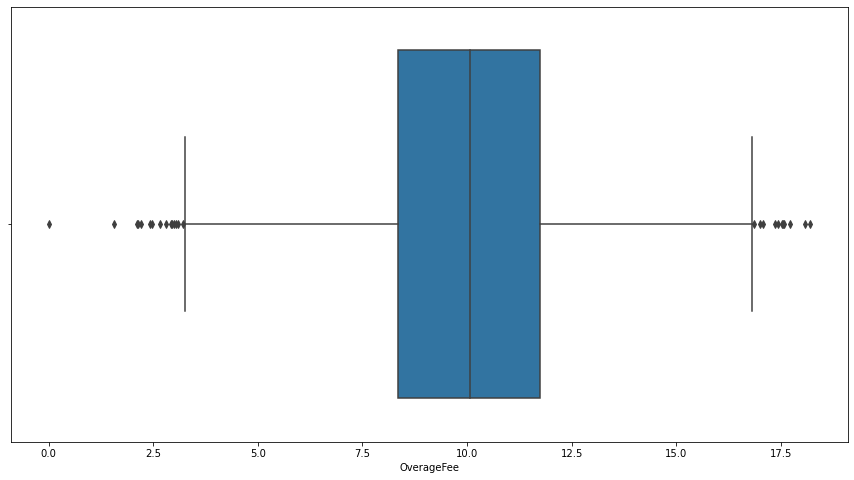

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


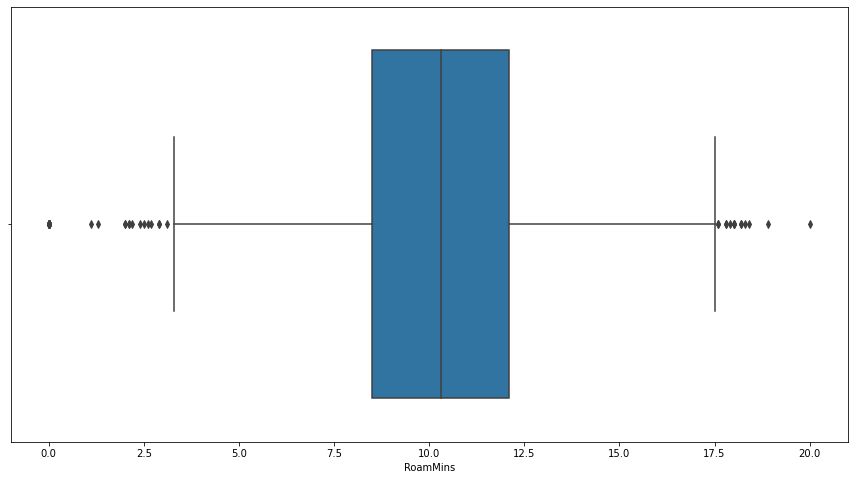

<Figure size 1080x576 with 0 Axes>

In [16]:
cols=['AccountWeeks','DataUsage','CustServCalls','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins'];

for i in cols:
    sns.boxplot(cell_df[i])
    plt.show()
    
plt.tight_layout()    


### Bi-Variate Analysis with Target variable

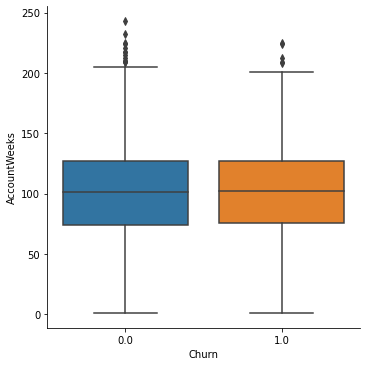

In [17]:
sns.catplot(data=cell_df, x='Churn', y='AccountWeeks', kind='box')

<b>Account Weeks and Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='AccountWeeks'>

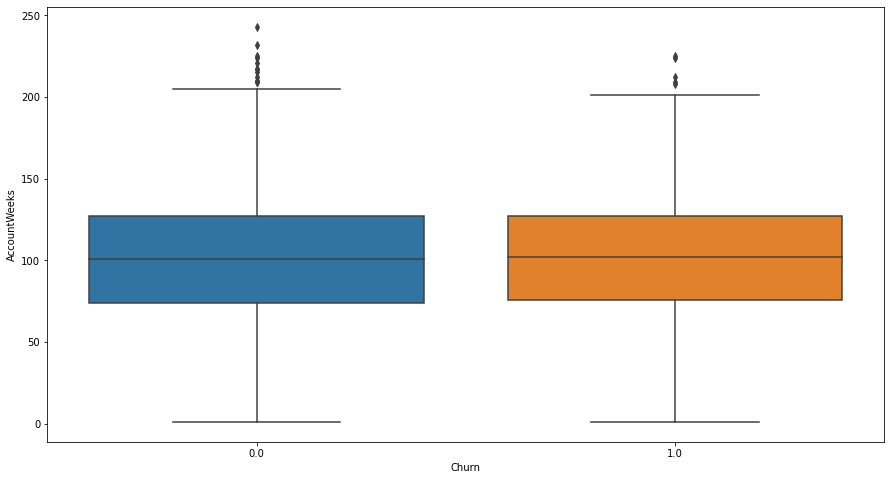

In [18]:
sns.boxplot(cell_df['Churn'],cell_df['AccountWeeks'])

<b>Data Usage against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='DataUsage'>

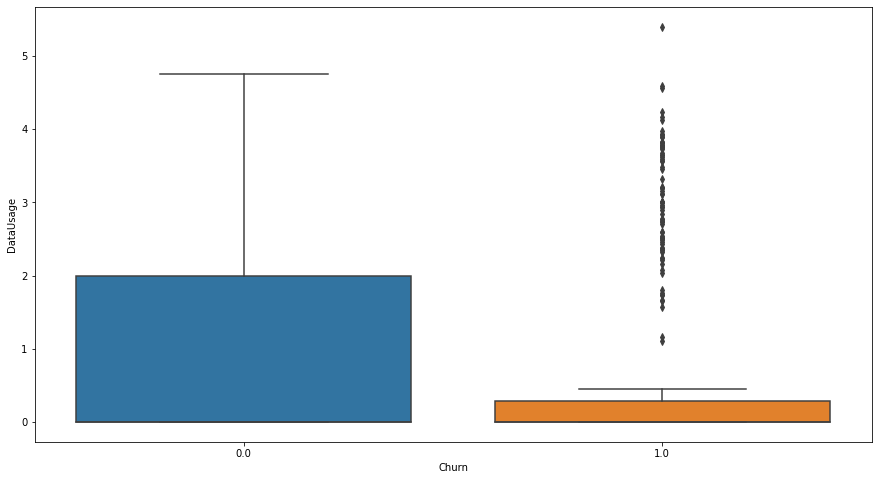

In [19]:
sns.boxplot(cell_df['Churn'],cell_df['DataUsage'])

<b>DayMins against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='DayMins'>

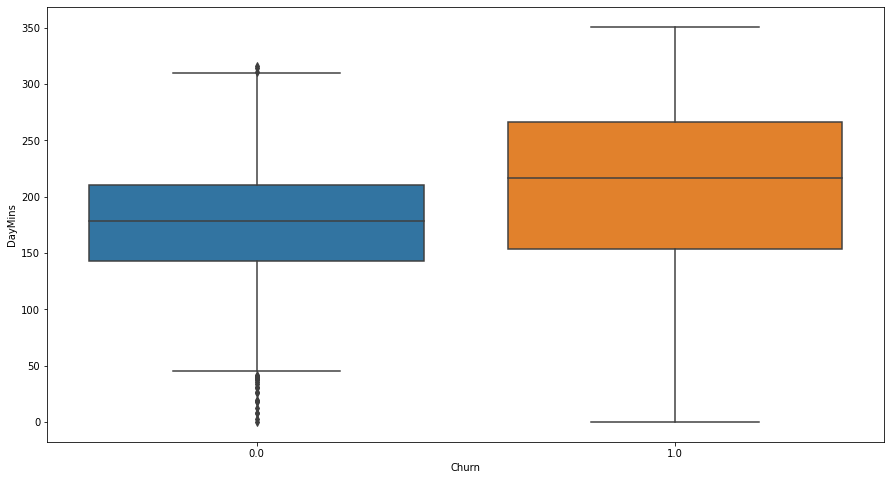

In [20]:
sns.boxplot(cell_df['Churn'],cell_df['DayMins'])

<b>DayCalls against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='DayCalls'>

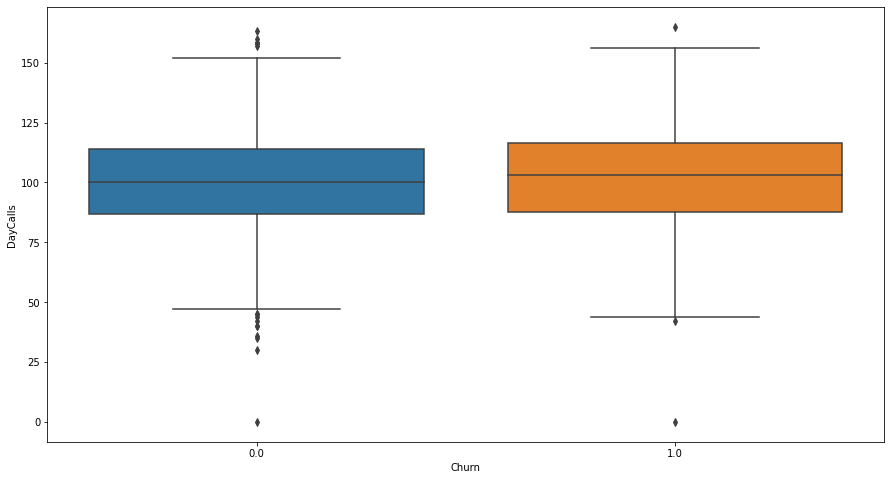

In [21]:
sns.boxplot(cell_df['Churn'],cell_df['DayCalls'])

<b>MonthlyCharge against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='MonthlyCharge'>

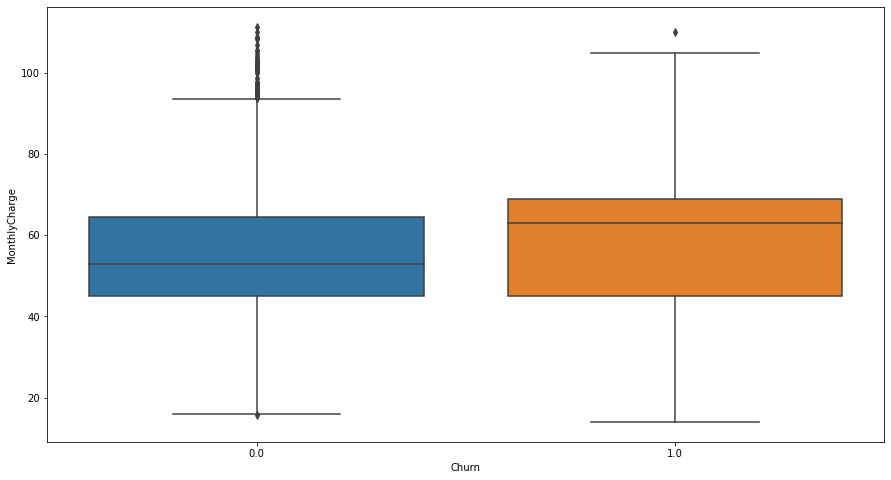

In [22]:
sns.boxplot(cell_df['Churn'],cell_df['MonthlyCharge'])

<b>OverageFee against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='OverageFee'>

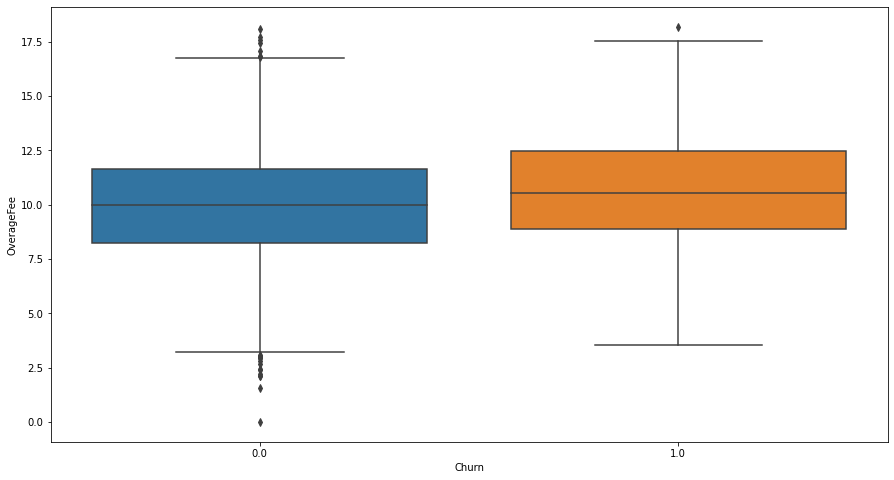

In [23]:
sns.boxplot(cell_df['Churn'],cell_df['OverageFee'])

<b>RoamMins against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='RoamMins'>

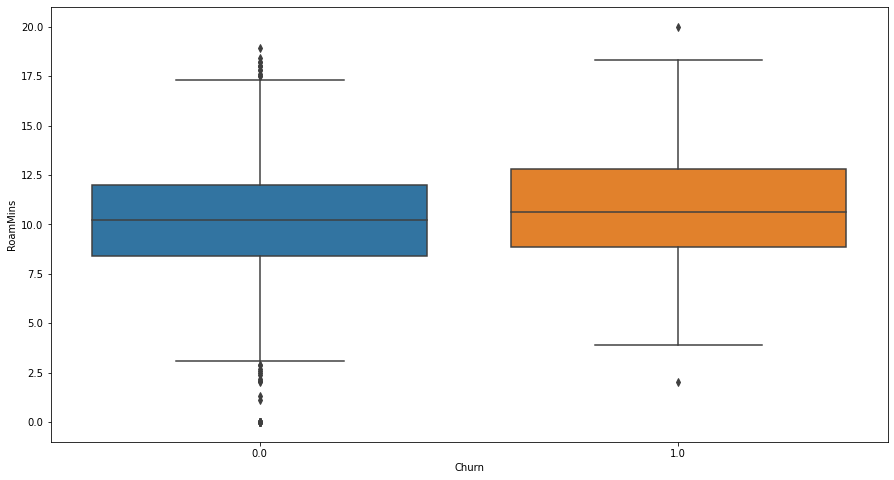

In [24]:
sns.boxplot(cell_df['Churn'],cell_df['RoamMins'])

<b>CustServCalls against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Churn', ylabel='CustServCalls'>

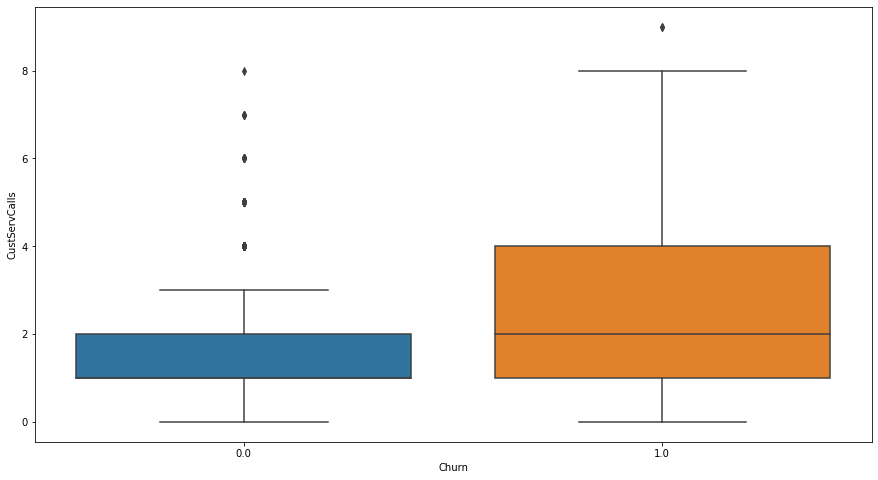

In [25]:
sns.boxplot(cell_df['Churn'],cell_df['CustServCalls'])

<b>Contract Renewal against Churn</b>

In [33]:
pd.crosstab(cell_df['ContractRenewal'], cell_df['Churn'], margins=True, normalize=True)

Churn,0.0,1.0,All
ContractRenewal,,,
0.0,0.055506,0.041104,0.09661
1.0,0.799580,0.103810,0.90339
All,0.855086,0.144914,1.00000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ContractRenewal', ylabel='count'>

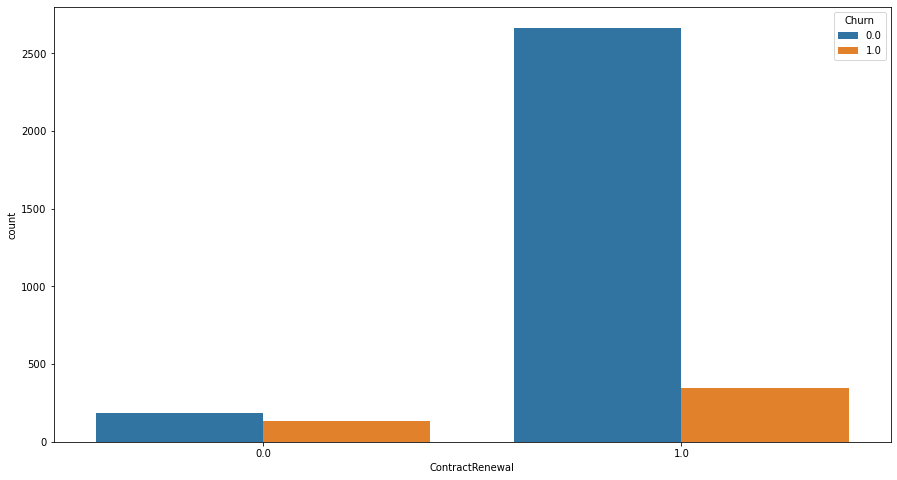

In [26]:
sns.countplot(cell_df['ContractRenewal'],hue=cell_df['Churn'])

<b>Data Plan against Churn</b>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DataPlan', ylabel='count'>

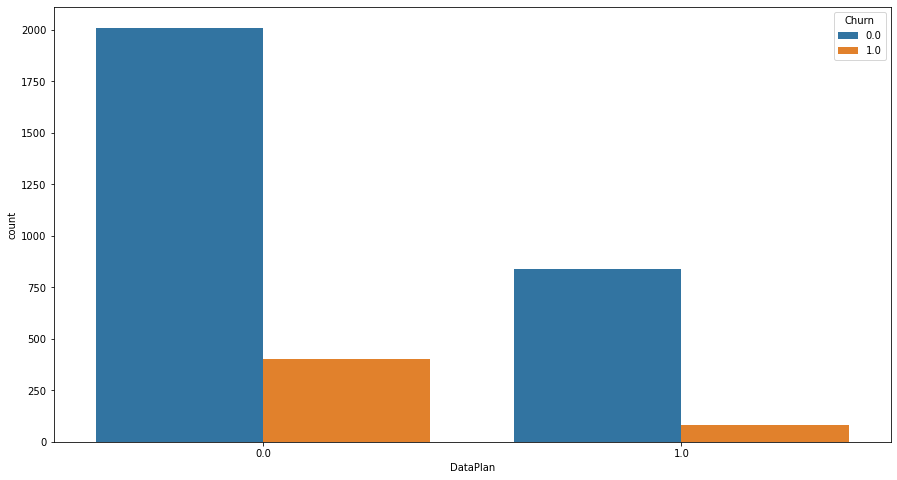

In [27]:
sns.countplot(cell_df['DataPlan'],hue=cell_df['Churn'])

In [34]:
cell_df_copy = cell_df.copy()

### Train (70%) - Test(30%) Split 

In [35]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve

### LDA Model

In [37]:
# Build LDA Model and fit the data
x = cell_df.drop(['Churn'])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=1,
                                                    stratify=y)

KeyError: "['Churn'] not found in axis"

### Prediction and Evaluation on both Training and Test Set using Confusion Matrix, Classification Report and AUC-ROC.

In [ ]:
# Predict it




In [ ]:
# Evaluation



